In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product d.csv', parse_dates=['Month-Year'])


In [3]:
sales_d= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_d = sales_d.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_d.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,96684,371027,879515
1,2019-02-01,99187,380632,902285
2,2019-03-01,113711,436369,1034407
3,2019-04-01,103982,399033,945904
4,2019-05-01,101826,390760,926291


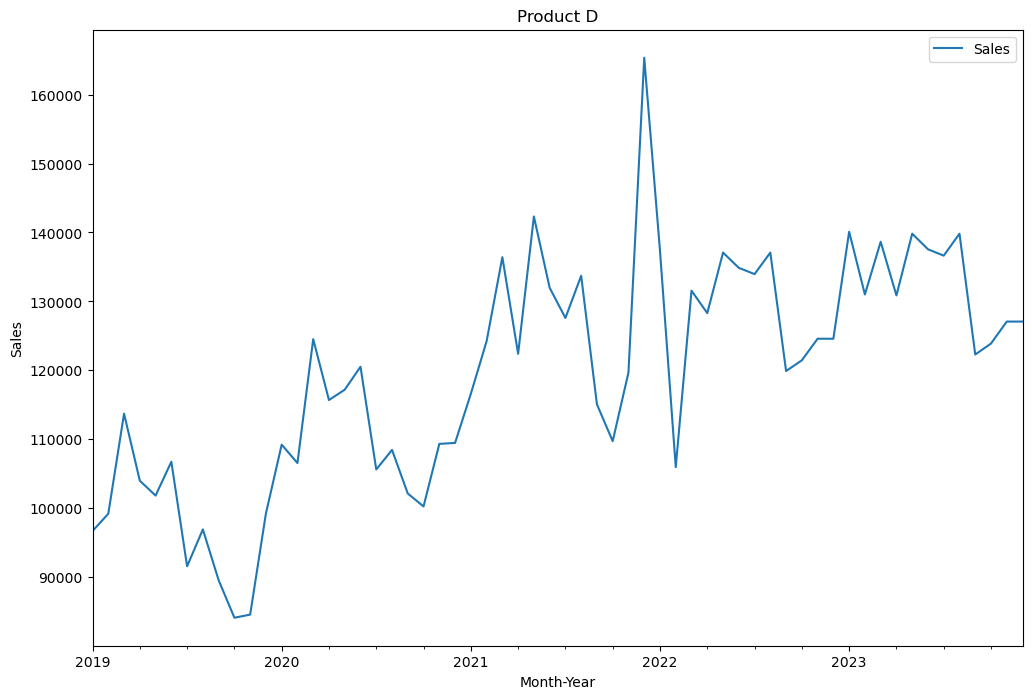

In [5]:
ax = sales_d.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product D')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_d[:57]
test=sales_d[57:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

11:07:26 - cmdstanpy - INFO - Chain [1] start processing
11:07:28 - cmdstanpy - INFO - Chain [1] done processing
11:07:32 - cmdstanpy - INFO - Chain [1] start processing
11:07:34 - cmdstanpy - INFO - Chain [1] done processing
11:07:39 - cmdstanpy - INFO - Chain [1] start processing
11:07:39 - cmdstanpy - INFO - Chain [1] done processing
11:07:46 - cmdstanpy - INFO - Chain [1] start processing
11:07:46 - cmdstanpy - INFO - Chain [1] done processing
11:07:51 - cmdstanpy - INFO - Chain [1] start processing
11:07:52 - cmdstanpy - INFO - Chain [1] done processing
11:07:58 - cmdstanpy - INFO - Chain [1] start processing
11:07:58 - cmdstanpy - INFO - Chain [1] done processing
11:08:03 - cmdstanpy - INFO - Chain [1] start processing
11:08:04 - cmdstanpy - INFO - Chain [1] done processing
11:08:11 - cmdstanpy - INFO - Chain [1] start processing
11:08:11 - cmdstanpy - INFO - Chain [1] done processing
11:08:17 - cmdstanpy - INFO - Chain [1] start processing
11:08:17 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   12155.638573  
1   13108.558130  
2   14847.983659  
3   15471.648377  
4   15694.133385  
..       

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
24,0.10,0.01,additive,11715.999662
36,0.20,0.01,additive,11774.091505
48,0.30,0.01,additive,11940.685313
12,0.01,0.01,additive,12029.009989
37,0.20,0.01,multiplicative,12115.978797
...,...,...,...,...
57,0.30,5.00,multiplicative,29172.654999
69,0.50,5.00,multiplicative,61663.916768
65,0.50,1.00,multiplicative,67046.841229
71,0.50,10.00,multiplicative,68513.768663


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.01, seasonality_mode= 'additive', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

11:43:21 - cmdstanpy - INFO - Chain [1] start processing
11:43:22 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

3

In [13]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [14]:
future_dates['Market Size'] = sales_d['Market Size']
future_dates['Marketing Expense'] = sales_d['Marketing Expense']

In [15]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,371027,879515
1,2019-02-01,380632,902285
2,2019-03-01,436369,1034407
3,2019-04-01,399033,945904
4,2019-05-01,390760,926291
5,2019-06-01,409602,970956
6,2019-07-01,351390,832967
7,2019-08-01,371925,881644
8,2019-09-01,343654,814628
9,2019-10-01,324474,769162


In [16]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [17]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [18]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
57,2023-10-01,125446.695186,112805.143510,137911.998833
58,2023-11-01,125788.728267,113309.392121,138894.618782
59,2023-12-01,140264.273243,127065.089675,152642.392461


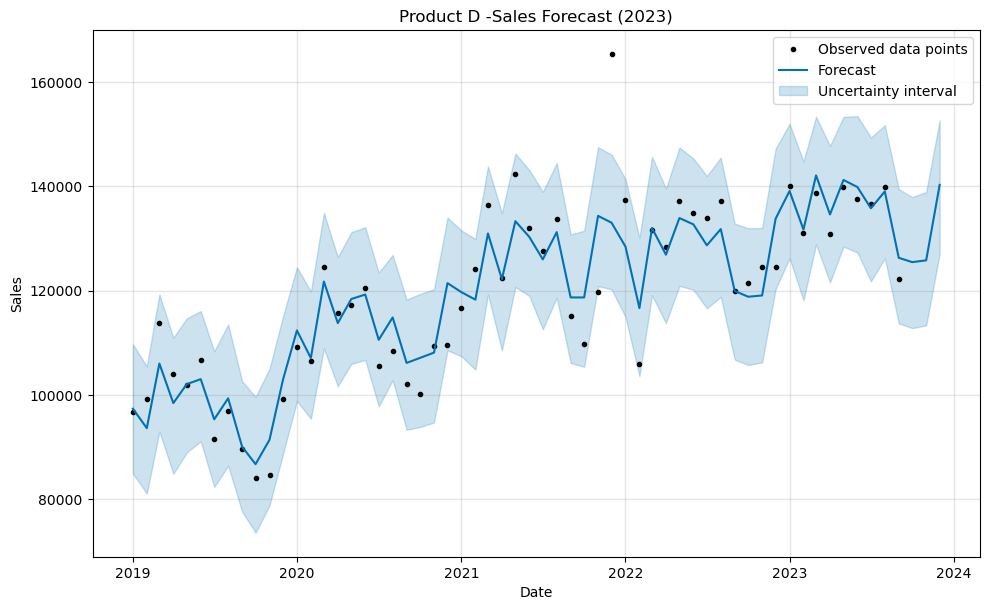

In [19]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product D -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

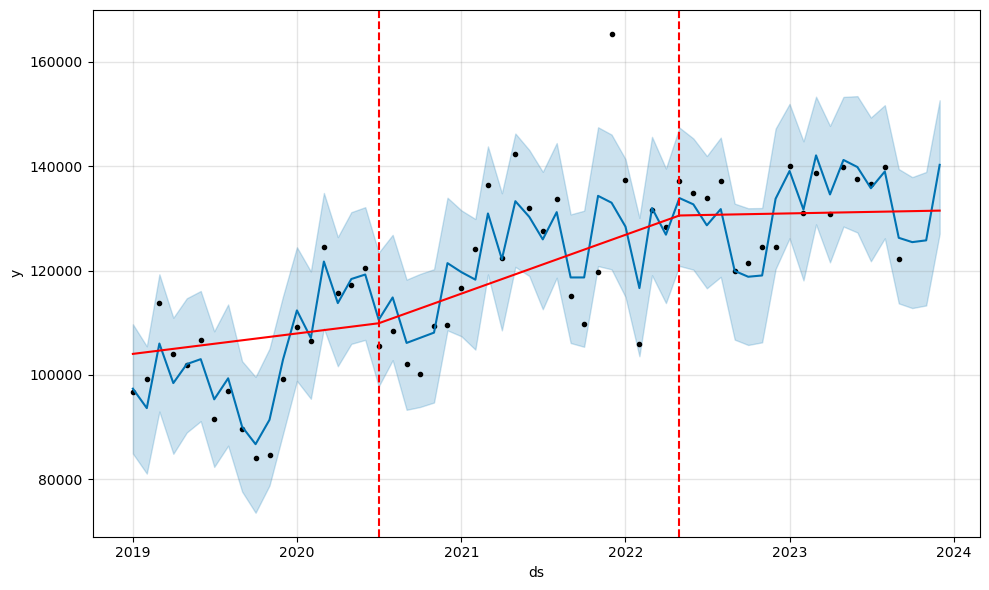

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

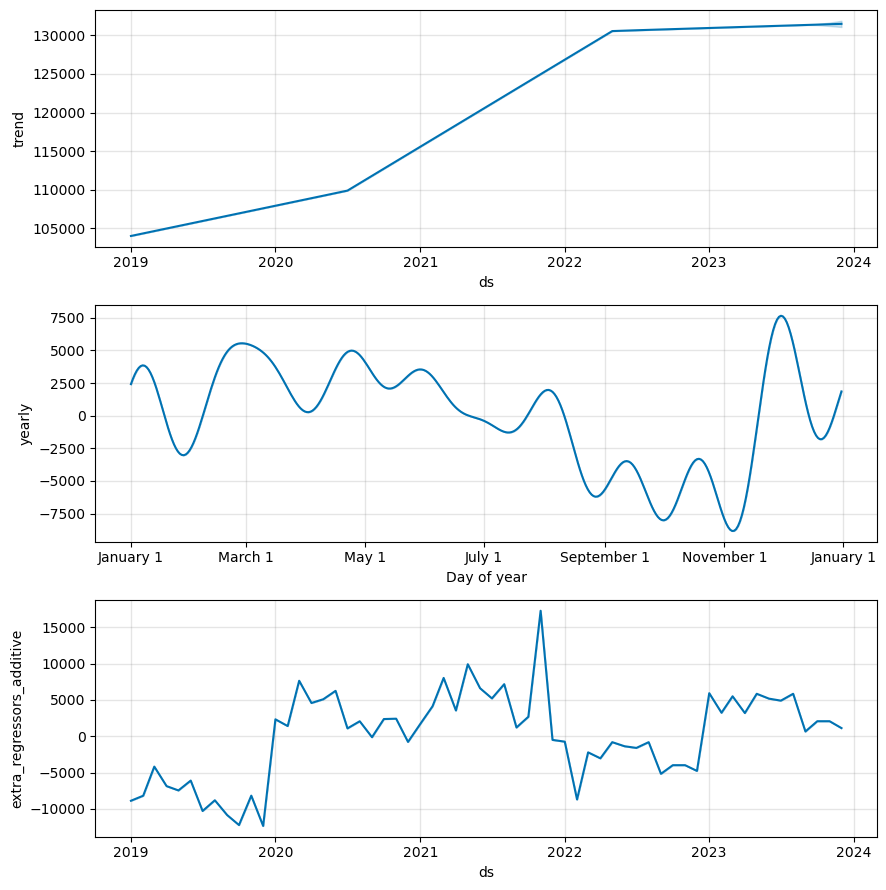

In [21]:
fig2 = model.plot_components(forecast)

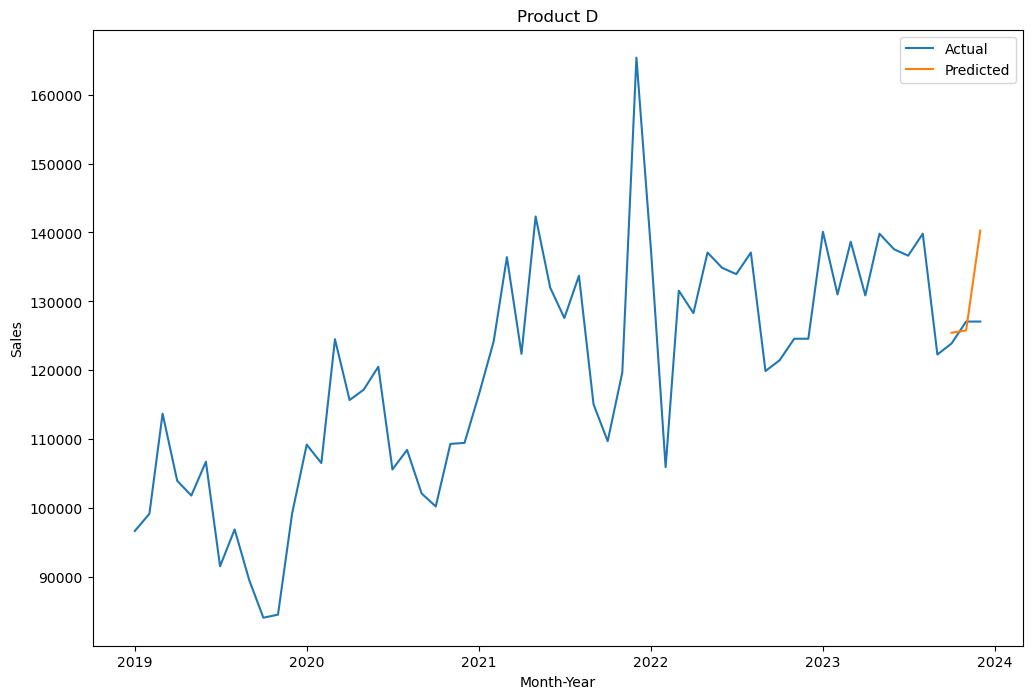

In [22]:
# Reset index of sales_b DataFrame
sales_d_reset_index = sales_d.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_d_reset_index['ds'], sales_d_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product D')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
#model evaluation

In [24]:
pred=forecasted_df['yhat']
test_df=test['y']

In [25]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 5345.080
MAPE - FB PROPHET: 0.042
MSE - FB PROPHET: 59355960.241
RMSE - FB PROPHET: 7704.282


In [26]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='90 days', horizon='90 days', parallel="processes")

In [27]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,20 days,5.090338e+07,7134.660140,6178.182769,0.053660,0.036595,0.051719,0.333333
1,22 days,6.270586e+07,7918.703235,6567.553109,0.054725,0.058065,0.053671,0.666667
2,23 days,2.332538e+07,4829.635803,3671.399982,0.026980,0.018323,0.027619,1.000000
3,25 days,1.637198e+07,4046.230847,3356.119734,0.025694,0.027450,0.025918,1.000000
4,27 days,5.317687e+07,7292.246937,6833.435476,0.051556,0.056032,0.050108,1.000000
5,28 days,4.950623e+07,7036.066418,5829.406002,0.043192,0.056032,0.041866,1.000000
6,47 days,2.724655e+07,5219.823224,3876.863727,0.028372,0.019151,0.027771,1.000000
7,49 days,7.285837e+06,2699.228941,2277.441471,0.016604,0.019151,0.016533,1.000000
8,51 days,3.250443e+08,18028.984907,12462.417660,0.101814,0.028304,0.091918,0.666667
9,52 days,3.254301e+08,18039.680788,12530.629669,0.102555,0.028304,0.092675,0.666667


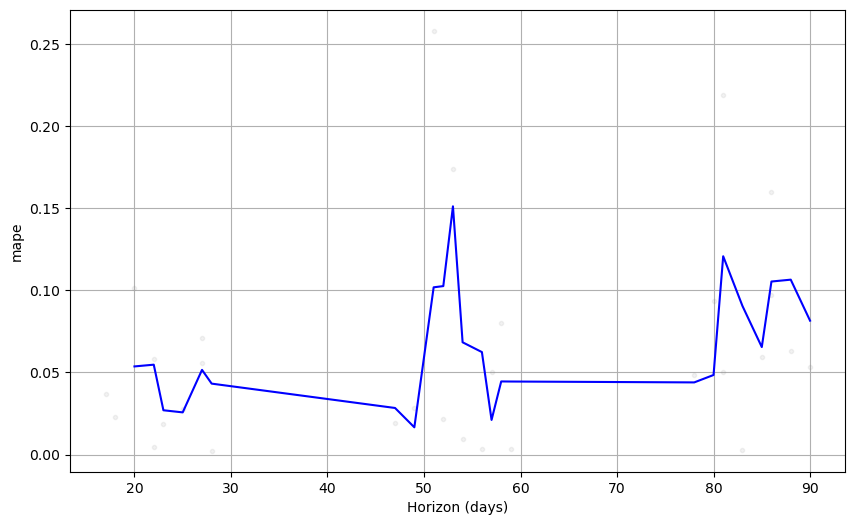

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [29]:
test_df

57    123887
58    127074
59    127074
Name: y, dtype: int64

In [30]:
pred

57    125446.695186
58    125788.728267
59    140264.273243
Name: yhat, dtype: float64